# Map rotation

The surface of the star is based on an healpix map, that we need to rotate in order to simulate the star's rotation

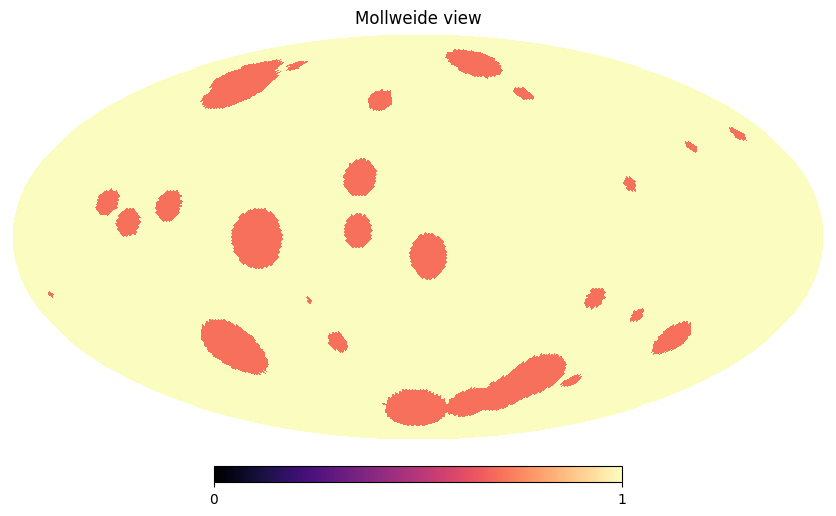

In [7]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from spotter import Star
from spotter import uniform

star = Star(N=2**6, u=[0.1, 0.2])
np.random.seed(42)
radius = np.random.uniform(0.01, 0.2, size=30)
star.add_spot(*uniform(30), radius, 0.3)

# limb darkening is only applied on disk so no point
# to show it here in this Mollewide projection
hp.mollview(star.map(), cmap="magma", min=0, max=1)

One way to perform the rotation is to use the `Rotation` object (and to project the result on a disk before multiplying it by the limb darkening law)

In [8]:
rotated_pixels = hp.Rotator(rot=np.pi / 4, deg=False).rotate_map_pixel(star.map())

But if we have to do that for say 1000 phases to compute the rotational light curve of the star (the disk-integrated flux) it can be very slow.

In [9]:
from time import time

phases = np.linspace(0, 2 * np.pi, 1000)

t0 = time()
for i in phases:
    rotated_pixels = hp.Rotator(rot=i, deg=False).rotate_map_pixel(star.map_spot)
    flux = np.sum(rotated_pixels)
print(f"{time() - t0:.2f} s")

7.69 s


So the idea is, instead of rotating the map, to rotate the point of view within the healpix sphere, compute a mask of the stellar disk being rotated, and compute the flux. This is illustrated below and implemented in the `Star` object

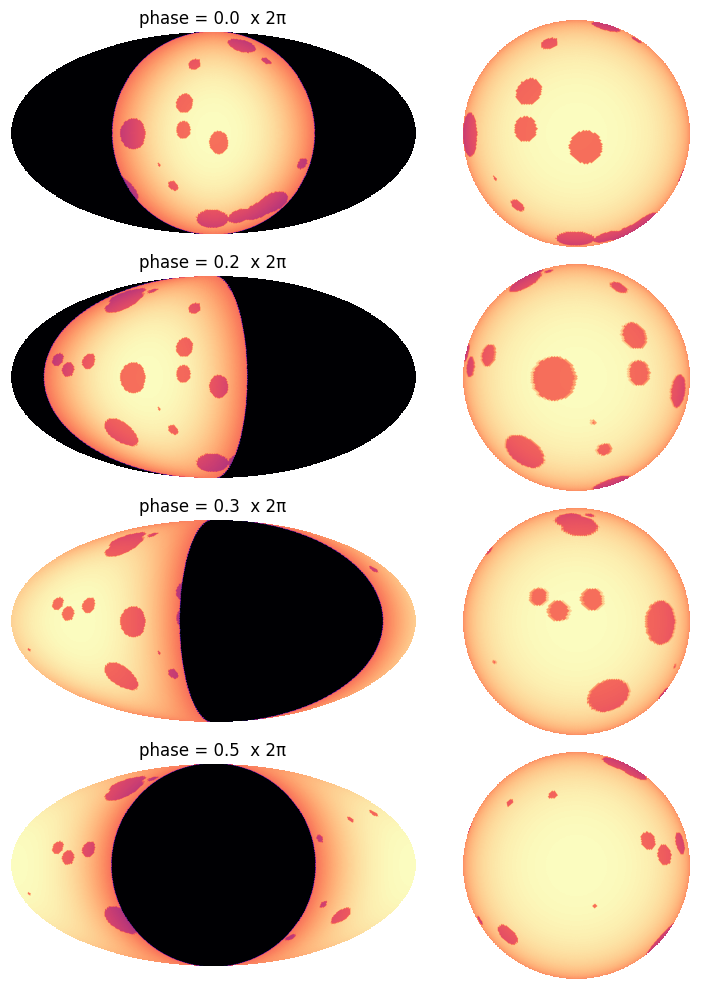

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(8, 10))

for i, phase in enumerate(np.linspace(0, np.pi, 4)):
    ax = axes[i, 0]
    star_map = star.map(phase=phase, limb_darkening=True)
    img = hp.mollview(star_map, return_projected_map=True)
    plt.close()
    ax.imshow(img, cmap="magma", vmin=0, vmax=1, origin="lower")
    ax.set_title(f"phase = {phase/2/np.pi:.1f}  x 2π")
    ax.axis("off")

    ax = axes[i, 1]
    star.show(phase=phase, ax=ax, vmin=0, vmax=1)

plt.tight_layout()

Let's make a small benchmark using the map above

In [11]:
from spotter import Star
from time import time

t0 = time()
f = star.flux(phases)
print(time() - t0)

1.0395169258117676


A bit faster. Now if we precompute the computation of the rotation mask with jax

In [12]:
flux = star.jax_flux(phases)
flux(star.map_spot)

t0 = time()
f = flux(star.map_spot)
print(time() - t0)

0.031226158142089844


Way faster!